In [1]:
# 基礎資料處理切分
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Deep Learning 相關
import torch
from torch import nn, optim, utils

# 系統互動
import time
import argparse

# 自訂部分
from model import ResNet50MothClassifier
from dataset import ImageDatasetFromFileSpecial
from average_meter import AverageMeter

In [2]:
# 讀取資料 & 前處理
dataset_path = 'sp_mod.csv'
df = pd.read_csv(dataset_path, sep="\t")

# 移除未鑑定到種的資料
df = df[~df.Species.isna()].reset_index(drop=True)

# 造出物種清單，並產生每筆資料對應的物種 id, 視為 classification 用的 target y
species_list, species_id = np.unique(df.Species, return_inverse=True)
y = species_id

# 產生影像路徑
x = img_paths = ('./downloaded256/' + df.Number + '.jpg').values

In [3]:
opt_dataroot = "./downloaded256/"
opt_batchSize = 20
# 切 train, valid, test
x_train_valid, x_test, y_train_valid, y_test = train_test_split(x, y,  train_size=.8, test_size=.2, random_state=5566)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid,  train_size=.8, test_size=.2, random_state=5566)

train_set = ImageDatasetFromFileSpecial(x_train, "", y=y_train, aug=True)
train_data_loader = utils.data.DataLoader(train_set, batch_size=opt_batchSize, shuffle=True)

# valid 與 test 時不需要做 augmentation
valid_set = ImageDatasetFromFileSpecial(x_valid, "", y=y_valid, aug=False)
valid_data_loader = utils.data.DataLoader(valid_set, batch_size=opt_batchSize, shuffle=False)

# 儲存模型
def save_checkpoint(model, model_out_path = "resnet50_moth_classifier.pth"):
    torch.save({"model": model}, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

# init model, 把模型搬進 GPU:0 的記憶體中
model = ResNet50MothClassifier(num_of_classes=len(species_list)).to('cuda:0')
# 設定 optimizer
adam = optim.Adam(model.parameters(), lr=5e-5, betas=(0.5, 0.999))
# 設定分類器用的 cross entropy loss
cross_entropy = nn.CrossEntropyLoss()

# init min loss criteria
min_criteria = np.inf

early_stop_threshold = 20
early_stop_counter = 0

# 開啟空白 log 檔
with open('./resnet50_moth_classifier.log','w') as loss_log:
    pass

Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.3.0


In [ ]:
# 計算總花費時數
start_time = time.time()
for epoch in range(0, 200 + 1):  

    # 簡單的平均值計算器
    train_loss = AverageMeter()
    valid_loss = AverageMeter()
    batch_time = AverageMeter()

    #--------------train------------
    model = model.train()
    for iteration, (auged, label) in enumerate(train_data_loader, 0):

        batch_start_time = time.time()
        auged_cuda = auged.to('cuda:0')
        pred = model(auged_cuda)
        # 注意在 model 中並沒有對輸出做 softmax
        # 因為 pytorch 在 cross entropy loss 裡面有內建了
        loss = cross_entropy(pred, label.to('cuda:0'))

        # 將前次的梯度歸零
        adam.zero_grad()
        # 計算本次的梯度
        loss.backward()
        # 更新模型參數
        adam.step()
        
        # 計算花費時數
        time_cost = time.time() - start_time
        batch_time_cost = time.time() - batch_start_time
        batch_time.update(batch_time_cost)
        
        # 紀錄 training loss per batch in a epoch
        train_loss.update(loss.item())

        info = "====> Training Epoch[{}]({}/{}); time:({:.2f}/{:.2f}); train loss:{:.2f}".format(epoch+1, iteration+1, len(train_data_loader), batch_time.avg, time_cost, train_loss.avg)
        print(info, end='\r')
        
        del auged_cuda, pred
    
    print()

    #--------------valid------------
    batch_time = AverageMeter()
    # 將模型設置成 eval 模式，固定住 weights, bias 等參數 (包括 batch norm)
    model = model.eval()
    for iteration, (img_for_valid, label) in enumerate(valid_data_loader, 0):

        batch_start_time = time.time()
        img_for_valid_cuda = img_for_valid.to('cuda:0')
        pred = model(img_for_valid_cuda)

        loss = cross_entropy(pred, label.to('cuda:0'))

        time_cost = time.time() - start_time
        batch_time_cost = time.time() - batch_start_time
        batch_time.update(batch_time_cost)
        
        # 紀錄 valid loss per batch in a epoch
        valid_loss.update(loss.item())

        info = "====> Validation ({}/{}): time:({:.2f}/{:.2f}): valid loss:{:.2f}".format(iteration+1, len(valid_data_loader), batch_time.avg, time_cost, valid_loss.avg)
        print(info, end='\r')

        del img_for_valid_cuda, pred
    
    print()    

    valid_loss_avg = valid_loss.avg

    criteria = valid_loss_avg

    # 如果 loss 差值太小無實質意義，可用 min_delta 控制
    min_delta = 0
    if min_criteria - criteria >= min_delta:
        min_criteria = criteria
        print ("Min criteria: %.2f" % min_criteria)
        save_checkpoint(model, model_out_path = "resnet50_moth_classifier.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print ("Early stop counter: %d" % early_stop_counter)

    if early_stop_counter > early_stop_threshold:
        print ("Early stopped.")
        break

    with open('./resnet50_moth_classifier.log','a') as loss_log:
        loss_log.write(
            "\t".join([
                str(epoch+1), 
                '%.2f' % time_cost,
                '%.2f' % train_loss.avg,
                '%.2f' % valid_loss.avg,
                '\n',
            ])
        )

torch.Size([20, 2048, 1, 1])
torch.Size([20, 2048, 1, 1])21); time:(0.36/0.67); train loss:7.95
torch.Size([20, 2048, 1, 1])21); time:(0.25/1.08); train loss:7.89
torch.Size([20, 2048, 1, 1])21); time:(0.21/1.56); train loss:7.85
torch.Size([20, 2048, 1, 1])21); time:(0.19/1.97); train loss:7.81
torch.Size([20, 2048, 1, 1])21); time:(0.18/2.40); train loss:7.82
torch.Size([20, 2048, 1, 1])21); time:(0.18/2.84); train loss:7.82
torch.Size([20, 2048, 1, 1])21); time:(0.17/3.21); train loss:7.82
torch.Size([20, 2048, 1, 1])21); time:(0.17/3.58); train loss:7.81
torch.Size([20, 2048, 1, 1])21); time:(0.16/4.01); train loss:7.80
torch.Size([20, 2048, 1, 1])721); time:(0.16/4.37); train loss:7.78
torch.Size([20, 2048, 1, 1])721); time:(0.16/4.85); train loss:7.77
torch.Size([20, 2048, 1, 1])721); time:(0.16/5.25); train loss:7.77
torch.Size([20, 2048, 1, 1])721); time:(0.15/5.70); train loss:7.78
torch.Size([20, 2048, 1, 1])721); time:(0.15/6.06); train loss:7.78
torch.Size([20, 2048, 1, 1])

In [1]:
import pandas as pd

In [1]:
logfile = pd.read_csv('resnet50_moth_classifier.log', sep='\t')

NameError: name 'pd' is not defined

In [10]:
logfile

,epoch,time,train_loss,valid_loss,dummy
0,1,573.35,4.39,2.36,NaN
1,2,1106.74,1.72,1.22,NaN
2,3,1632.97,0.86,0.84,NaN
3,4,2159.32,0.52,0.75,NaN
4,5,2686.28,0.36,0.71,NaN
5,6,3215.00,0.27,0.65,NaN
6,7,3743.16,0.22,0.68,NaN
7,8,4271.59,0.19,0.65,NaN
8,9,4801.09,0.16,0.68,NaN
9,10,5327.86,0.14,0.70,NaN


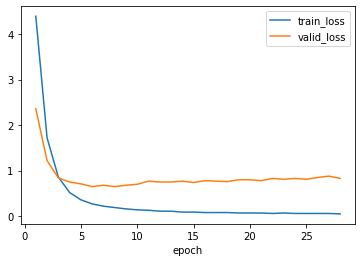

In [11]:
logfile.plot(x='epoch', y=['train_loss', 'valid_loss'])